In [ ]:
!pip install celltypist==1.5.3

In [1]:
from os.path import join

import anndata
import scanpy as sc
import numpy as np
import pandas as pd
import dask.dataframe as dd

from scipy.sparse import csr_matrix
from tqdm.auto import tqdm

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'
CKPT_PATH = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_celltypist/model_1500000_cells_run1.pkl'

In [3]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))
y_true = dd.read_parquet(join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()

# Load model & predict cell types

In [4]:
import celltypist

Loading faiss with AVX2 support.
Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
Loading faiss.
Successfully loaded faiss.


In [5]:
def get_count_matrix(ddf):
    x = (
        ddf['X']
        .map_partitions(
            lambda xx: pd.DataFrame(np.vstack(xx.tolist())), 
            meta={col: 'f4' for col in range(19331)}
        )
        .to_dask_array(lengths=[1024] * ddf.npartitions)
    )
    
    return x


In [6]:
ddf = dd.read_parquet(join(DATA_PATH, 'test'), split_row_groups=True)
x = get_count_matrix(ddf)
var = pd.read_parquet(join(DATA_PATH, 'var.parquet'))

In [ ]:
# run inference in batches to save memory
preds = []

for i, idxs in tqdm(enumerate(np.array_split(np.arange(x.shape[0]), 10))):
    # data is already normalized
    adata_test = anndata.AnnData(
        X=x[idxs, :].map_blocks(csr_matrix).compute(), 
        var=var.set_index('feature_name')
    )
    preds.append(celltypist.annotate(adata_test, model=CKPT_PATH))


y_pred = np.concatenate([batch.predicted_labels.to_numpy().flatten() for batch in preds])

# Classification performance

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

from utils import correct_labels

#### Overall performance

In [9]:
y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)

In [10]:
clf_report = pd.DataFrame(classification_report(y_true, y_pred_corr, output_dict=True)).T
clf_report_overall = clf_report.iloc[-3:].copy()
clf_report_per_class = clf_report.iloc[:-3].copy()

clf_report_overall

,precision,recall,f1-score,support
accuracy,0.844417,0.844417,0.844417,8.444175e-01
macro avg,0.758372,0.725005,0.730413,3.448832e+06
weighted avg,0.845431,0.844417,0.839881,3.448832e+06


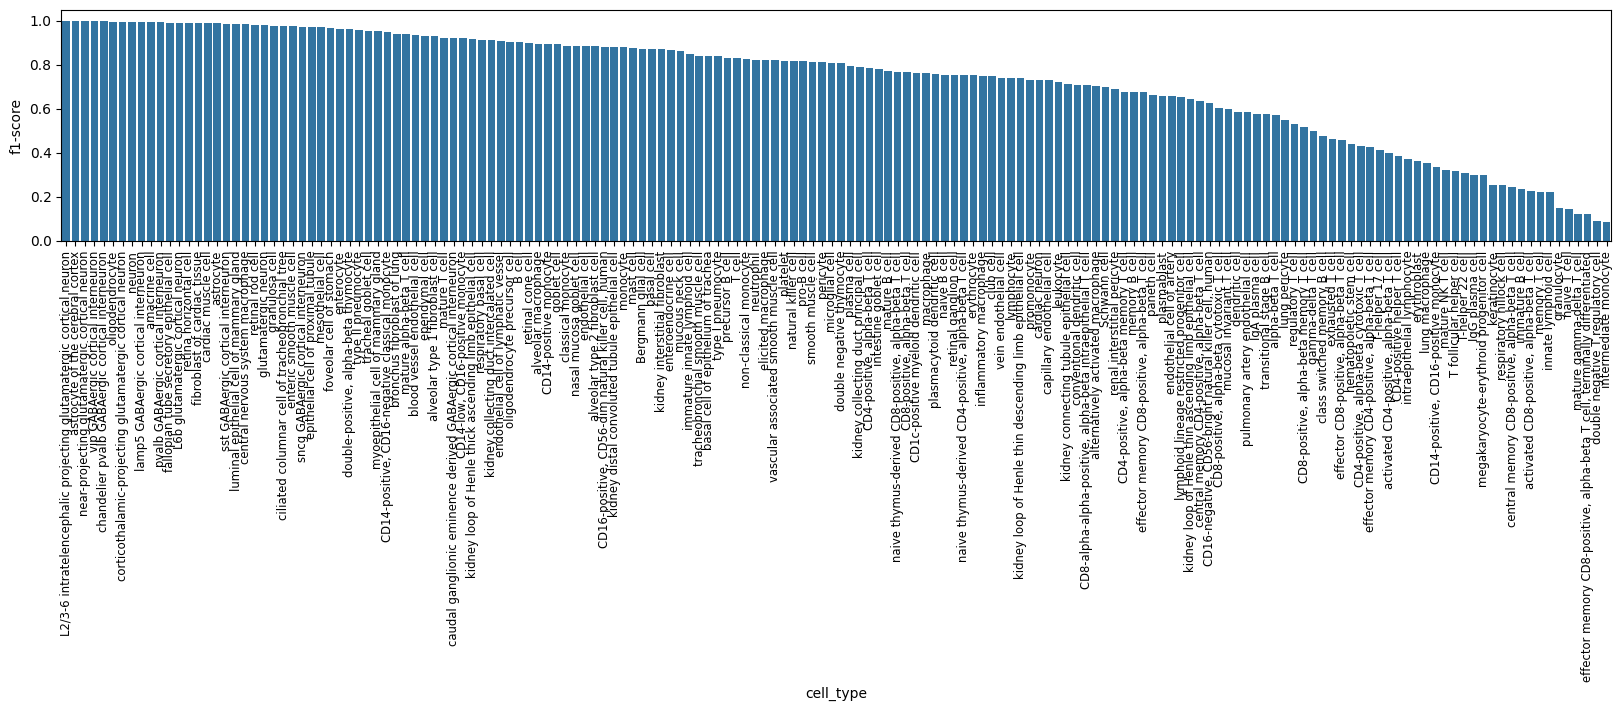

In [11]:
plt.rcParams['figure.figsize'] = (20, 3)

ax = sns.barplot(
    data=(
        clf_report_per_class
        .assign(
            cell_type=lambda df: df.index.to_series().astype(int).replace(cell_type_mapping['label'].to_dict())
        )
        .sort_values('f1-score', ascending=False)
    ),
    x='cell_type',
    y='f1-score',
    color='#1f77b4',
)
ax.tick_params(axis='x', labelrotation=90)
ax.xaxis.set_tick_params(labelsize='small');